In [ ]:
!pip install xgboost

In [1]:
# Importing required libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib
from sklearn.model_selection import train_test_split
# Set the global font to SF Pro Text
matplotlib.rcParams['font.family'] = 'SF Pro Text'

In [2]:
# Loading the Sales.csv data
df = pd.read_csv('Dataset/Sales.csv')
df.head()

,Order Date,Sales
0,2011-01-01,2425.12600
1,2011-01-02,942.44000
2,2011-01-03,13509.07440
3,2011-01-04,8426.74048
4,2011-01-05,10988.62000


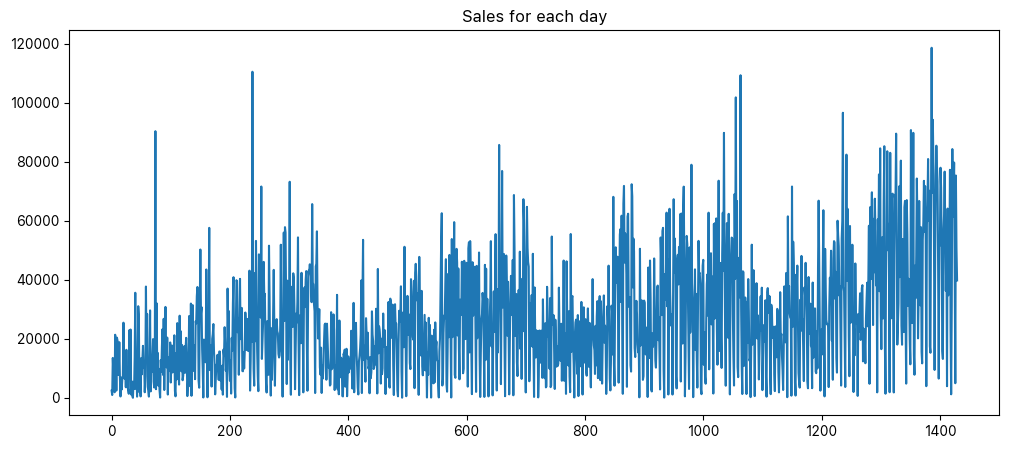

In [3]:
df['Sales'].plot(figsize=(12,5))
plt.title('Sales for each day')
plt.show()

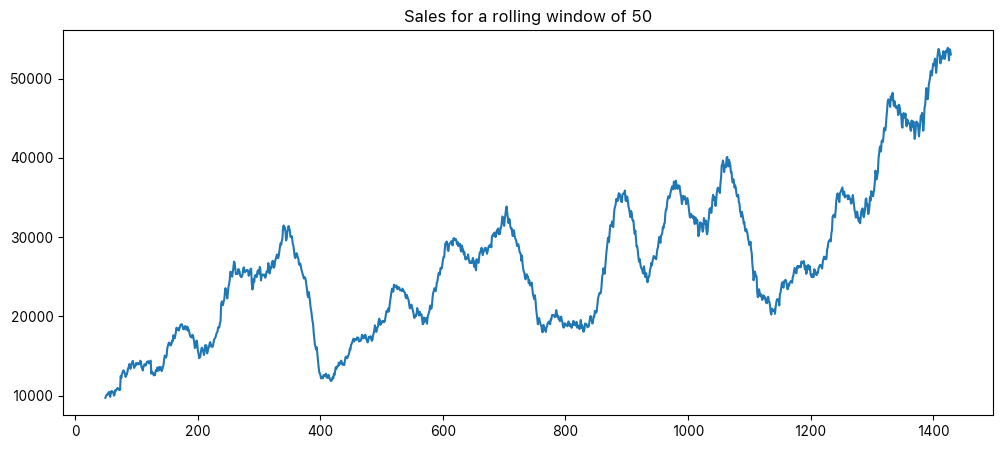

In [4]:
# sales data is highly volatile. 
# Using rolling mean smoothing of 50 day window to reduce the noise.

df['Sales'].rolling(window=50).mean().plot(figsize=(12,5))
plt.title('Sales for a rolling window of 50')
plt.show()

We can see the noise has been reduced when 50 day moving averages of sales are used.

In [5]:
df_smoothed = df.copy()

In [6]:
df_smoothed['Sales'] = df['Sales'].rolling(window=50).mean()
df_smoothed.head(60)

,Order Date,Sales
0,2011-01-01,NaN
1,2011-01-02,NaN
2,2011-01-03,NaN
3,2011-01-04,NaN
4,2011-01-05,NaN
5,2011-01-06,NaN
6,2011-01-07,NaN
7,2011-01-08,NaN
8,2011-01-09,NaN
9,2011-01-10,NaN


In [7]:
# Drop NaN values (first 50 rows will be NaN)
df_smoothed = df_smoothed.dropna().reset_index(drop=True)
df_smoothed.head()

,Order Date,Sales
0,2011-02-19,9729.299287
1,2011-02-21,9949.902487
2,2011-02-22,10089.859447
3,2011-02-23,10080.936999
4,2011-02-24,10264.480011


In [8]:
df_smoothed.shape

(1381, 2)

The data has 1381 rows and 2 columns

In [9]:
df_smoothed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1381 entries, 0 to 1380
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order Date  1381 non-null   object 
 1   Sales       1381 non-null   float64
dtypes: float64(1), object(1)
memory usage: 21.7+ KB


It can be observed that the datatype of Order Date is String. We need to convert to Datetime format.

In [10]:
# Converting the Order Date column datatype from string to Datetime.
df_smoothed['Order Date'] = pd.to_datetime(df_smoothed['Order Date'], format='%Y-%m-%d')

In [11]:
# Check last few dates
print(df_smoothed['Order Date'].tail(15))  

1366   2014-12-17
1367   2014-12-18
1368   2014-12-19
1369   2014-12-20
1370   2014-12-21
1371   2014-12-22
1372   2014-12-23
1373   2014-12-24
1374   2014-12-25
1375   2014-12-26
1376   2014-12-27
1377   2014-12-28
1378   2014-12-29
1379   2014-12-30
1380   2014-12-31
Name: Order Date, dtype: datetime64[ns]


In [12]:
df_for_training = df_smoothed[['Order Date', 'Sales']].copy()

In [19]:
# Split data before scaling
train_data, test_data = train_test_split(df_for_training, test_size=0.30, random_state=42, shuffle=False)

In [13]:
# Split data before scaling
train_data, test_data = train_test_split(df_for_training, test_size=0.30, shuffle=False)

In [14]:
train_data.tail()

,Order Date,Sales
961,2013-11-02,32070.337844
962,2013-11-04,31653.978130
963,2013-11-05,32488.683970
964,2013-11-06,32219.521026
965,2013-11-07,31745.817162


In [16]:
test_data.head()

,Order Date,Sales
966,2013-11-08,32200.446236
967,2013-11-09,31526.585085
968,2013-11-10,30124.233202
969,2013-11-11,30439.689385
970,2013-11-12,30965.818909


In [22]:
# Standardizing the sales values using StandardScaler()
# Fit scaler only on training data
scaler = StandardScaler().fit(train_data[['Sales']])
# Transform both train and test data using the same scaler
train_scaled = scaler.transform(train_data[['Sales']])
test_scaled  = scaler.transform(test_data[['Sales']])

In [23]:
# Define past and future time steps
n_future = 1     # Number of days to predict in the future
n_past   = 30    # Number of past days used to make a prediction

# Function to create sequences for time series forecasting
def create_sequences(data, past, future, dates):
    X, Y, date_list = [], [], []
    for i in range(past, len(data) - future + 1):
        X.append(data[i - past:i, 0])
        Y.append(data[i + future - 1, 0])
        date_list.append(dates.iloc[i + future - 1])
    return np.array(X), np.array(Y), np.array(date_list)

In [24]:
# Prepare training and testing data
X_train, y_train, train_dates = create_sequences(train_scaled, n_past, n_future, train_data['Order Date'])
X_test, y_test, test_dates    = create_sequences(test_scaled, n_past, n_future, test_data['Order Date'])

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [25]:
# Printing the shapes of train and test datasets.
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(936, 30, 1) (936,)
(385, 30, 1) (385,)


1. LSTM 

In [26]:
# Function to build and compile LSTM model
def build_lstm_model():
    model = Sequential(name="LSTM_Sales_Forecasting_Model")
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2]), name="Input_Layer"))
    model.add(LSTM(512, activation='tanh', return_sequences=True, name="LSTM_Layer_1"))
    model.add(LSTM(256, activation='tanh', return_sequences=False, name="LSTM_Layer_2"))
    model.add(Dense(128,name='Intermediate_Layer_1'))
    model.add(Dense(64,name='Intermediate_Layer_2'))
    model.add(Dense(y_train.ndim, name="Output_Layer"))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    return model

In [27]:
# Train LSTM model
lstm_model = build_lstm_model()
lstm_model.summary(show_trainable=True)

Model: "LSTM_Sales_Forecasting_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                          ┃ Output Shape                  ┃        Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ LSTM_Layer_1 (LSTM)                   │ (None, 30, 512)               │      1,052,672 │    Y    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ LSTM_Layer_2 (LSTM)                   │ (None, 256)                   │        787,456 │    Y    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ Intermediate_Layer_1 (Dense)          │ (None, 128)                   │         32,896 │    Y    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ Intermediate_Layer_2 (Dense)          │ (None, 64)                    │          8,256 │    Y    │
├───────────────────────────────────────┼───────────────────────────────┼────────────────┼─────────┤
│ Output_Layer (Dense)                  │ (None, 1)                     │             65 │    Y    │
└───────────────────────────────────────┴───────────────────────────────┴────────────────┴─────────┘

 Total params: 1,881,345 (7.18 MB)

 Trainable params: 1,881,345 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Fitting the model

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),  # Stops training if val_loss doesn't improve for 5 epochs
    ModelCheckpoint(filepath='LSTM_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1),  # Saves the best model
    ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)  # Reduces learning rate if val_loss plateaus
    ]

lstm_model.fit(X_train,  # Input training data (past sequences)
               y_train,  # Target values (future predictions)
               epochs=50,   # Number of times the model will see the entire dataset
               batch_size=32,  # Number of samples processed before updating model weights
               validation_data=(X_test, y_test), # Validation data
               verbose=1,  # Displays tr5aining progress
               callbacks=callbacks  # Include callbacks
               ) 

Epoch 1/50
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.4297
Epoch 1: val_loss improved from inf to 0.31061, saving model to LSTM_best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 0.4151 - val_loss: 0.3106 - learning_rate: 1.0000e-04
Epoch 2/50
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0561
Epoch 2: val_loss improved from 0.31061 to 0.15894, saving model to LSTM_best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0555 - val_loss: 0.1589 - learning_rate: 1.0000e-04
Epoch 3/50
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0271
Epoch 3: val_loss improved from 0.15894 to 0.10238, saving model to LSTM_best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.0269 - val_loss: 0.1024 - learning_rate: 1.0000e-04
Epoch 4/50
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0166
Epoch 4: val_loss improved from 0.10238 to 0.04578, saving model to LSTM_best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0166 - val_loss: 0.045

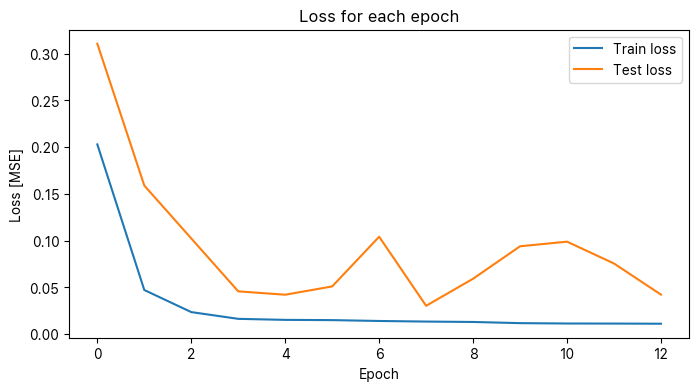

In [29]:
# Plot the losses for train and test data

plt.figure(figsize=(8,4))
plt.plot(lstm_model.history.history['loss'], label='Train loss')
plt.plot(lstm_model.history.history['val_loss'], label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss [MSE]')
plt.title('Loss for each epoch')
plt.legend()
plt.show()

In [30]:
# Function to make predictions and scale back results
def predict_and_inverse_transform(model, X, scaler):
    predictions = model.predict(X)
    predictions_copies = np.repeat(predictions, 1, axis=-1)  # Ensure correct shape
    if predictions_copies.ndim == 1:
        predictions_copies = predictions_copies.reshape(-1, 1)
    return scaler.inverse_transform(predictions_copies)[:, 0]

In [31]:
# Predict sales for train and test datasets
y_pred_train = predict_and_inverse_transform(lstm_model, X_train, scaler)
y_pred_test  = predict_and_inverse_transform(lstm_model, X_test, scaler)

df_comparison_train = pd.DataFrame({'Order Date': train_dates, 
                                   'Actual Sales': scaler.inverse_transform(y_train.reshape(-1, 1))[:, 0], 
                                   'Predicted Sales': y_pred_train})
df_comparison_test  = pd.DataFrame({'Order Date': test_dates, 
                                   'Actual Sales': scaler.inverse_transform(y_test.reshape(-1, 1))[:, 0], 
                                   'Predicted Sales': y_pred_test})

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [32]:
# Function to generate future predictions
def generate_future_predictions(model, last_input, future_days, scaler):
    future_predictions = []
    future_input = last_input.copy()
    for _ in range(future_days):
        pred = model.predict(future_input).ravel()[0]
        future_predictions.append(pred)
        future_input = np.roll(future_input, shift=-1, axis=1)
        if future_input.ndim == 3:
            future_input[0, -1, 0] = pred  # Ensure correct dimension indexing
        else:
            future_input[0, -1] = pred
    return scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))[:, 0]

In [33]:
# Generate future predictions
future_prediction_days = 30 
future_input           = X_test[-1:].copy()  # Use the last available test data
predict_period_dates   = pd.date_range(test_dates[-1], periods=future_prediction_days + 1).tolist()[1:]

In [34]:
y_future_pred_lstm     = generate_future_predictions(lstm_model, future_input, future_prediction_days, scaler)
df_future_lstm         = pd.DataFrame({'Order Date': predict_period_dates, 'Predicted Sales': y_future_pred_lstm})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

In [35]:
# Function to evaluate model performance
def evaluate_model(train, test, model_name):
    train_mse = mean_squared_error(train['Actual Sales'], train['Predicted Sales'])
    train_mae = mean_absolute_error(train['Actual Sales'], train['Predicted Sales'])
    train_r2  = r2_score(train['Actual Sales'], train['Predicted Sales'])

    test_mse = mean_squared_error(test['Actual Sales'], test['Predicted Sales'])
    test_mae = mean_absolute_error(test['Actual Sales'], test['Predicted Sales'])
    test_r2  = r2_score(test['Actual Sales'], test['Predicted Sales'])
    
    print(f"{model_name} Performance:")
    print('')
    print('Train Scores')
    print('')
    print(f"Train MSE: {train_mse:.4f}")
    print(f"Train MAE: {train_mae:.4f}")
    print(f"Train R2 Score: {train_r2:.4f}\n")
    print('Test Scores')
    print('')
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Test R2 Score: {test_r2:.4f}\n")

In [36]:
# Evaluate LSTM model
evaluate_model(df_comparison_train, df_comparison_test, "LSTM Model")

LSTM Model Performance:

Train Scores

Train MSE: 658849.5488
Train MAE: 645.5522
Train R2 Score: 0.9843

Test Scores

Test MSE: 1370190.9045
Test MAE: 909.8151
Test R2 Score: 0.9849



In [37]:
def plot_sales(train, test, df_future, title):
    plt.figure(figsize=(15,6))
    sns.lineplot(data=train, x='Order Date', y='Actual Sales', label='Actual Train Sales')
    sns.lineplot(data=train, x='Order Date', y='Predicted Sales', label='Predicted Train Sales')

    sns.lineplot(data=test, x='Order Date', y='Actual Sales', label='Actual Test Sales')
    sns.lineplot(data=test, x='Order Date', y='Predicted Sales', label='Predicted Test Sales')
    
    if df_future is not None:
        sns.lineplot(data=df_future, x='Order Date', y='Predicted Sales', label='Future Predictions')
    plt.xlabel("Order Date")
    plt.ylabel("Sales [Standardized]")
    plt.legend()
    plt.title(title)
    #plt.xticks(pd.concat([train[['Order Date']],test[['Order Date']]]).values.ravel(),rotation=0)
    plt.xticks(pd.date_range(start=train['Order Date'].min(), 
                             end=df_future['Order Date'].max(), freq='4ME').strftime('%Y-%m-%d'), rotation=0)
    plt.show()

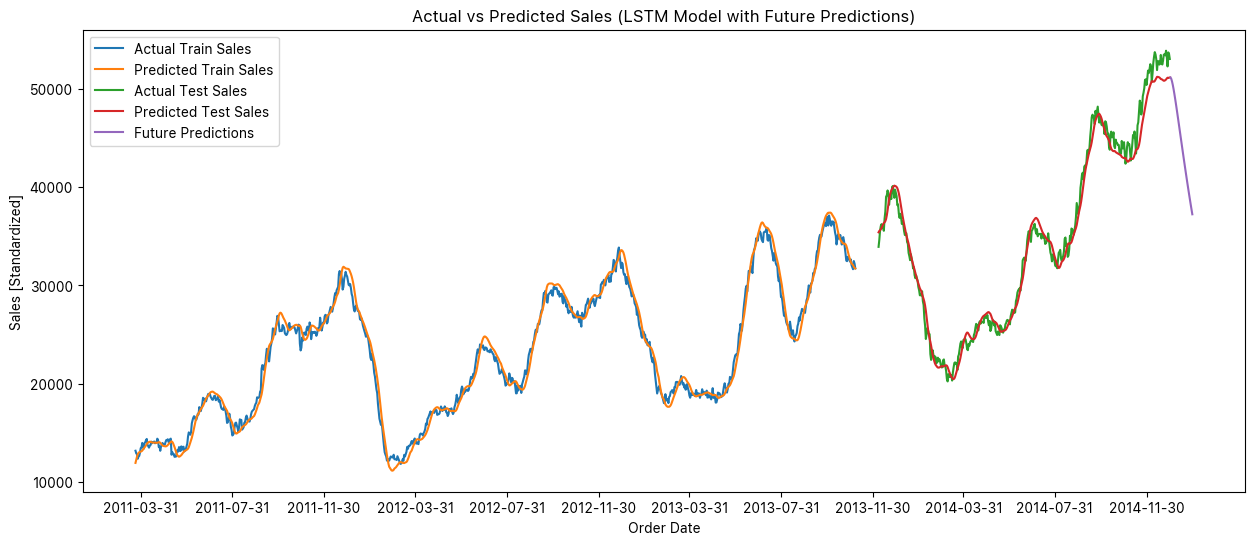

In [38]:
# Plot results
plot_sales(df_comparison_train, df_comparison_test, df_future_lstm, "Actual vs Predicted Sales (LSTM Model with Future Predictions)")

2. Random Forest Regressor

In [44]:
# Prepare data for RandomForestRegressor
X_train_rf = X_train.reshape(X_train.shape[0], -1)
X_test_rf  = X_test.reshape(X_test.shape[0], -1)

rf_model   = RandomForestRegressor(n_estimators=50,
                                   random_state=24)
rf_model.fit(X_train_rf, y_train)

RandomForestRegressor(n_estimators=50, random_state=24)

In [45]:
# Predict sales for train and test datasets
y_pred_train_rf = predict_and_inverse_transform(rf_model, X_train_rf, scaler)
y_pred_test_rf  = predict_and_inverse_transform(rf_model, X_test_rf, scaler)

df_comparison_train_rf = pd.DataFrame({'Order Date': train_dates, 
                                       'Actual Sales': scaler.inverse_transform(y_train.reshape(-1, 1))[:, 0], 
                                       'Predicted Sales': y_pred_train_rf})
df_comparison_test_rf  = pd.DataFrame({'Order Date': test_dates, 
                                       'Actual Sales': scaler.inverse_transform(y_test.reshape(-1, 1))[:, 0], 
                                       'Predicted Sales': y_pred_test_rf})

In [46]:
future_input_rf    = X_test_rf[-1:].copy()  # Use the last available test data
y_future_pred_rf   = generate_future_predictions(rf_model, future_input_rf, future_prediction_days, scaler)
df_future_rf       = pd.DataFrame({'Order Date': predict_period_dates, 'Predicted Sales': y_future_pred_rf})

In [47]:
# Evaluate LSTM model
evaluate_model(df_comparison_train_rf, df_comparison_test_rf, "Random Forest Regressor Model")

Random Forest Regressor Model Performance:

Train Scores

Train MSE: 29826.7530
Train MAE: 134.5006
Train R2 Score: 0.9993

Test Scores

Test MSE: 41438324.3372
Test MAE: 3783.6777
Test R2 Score: 0.5426



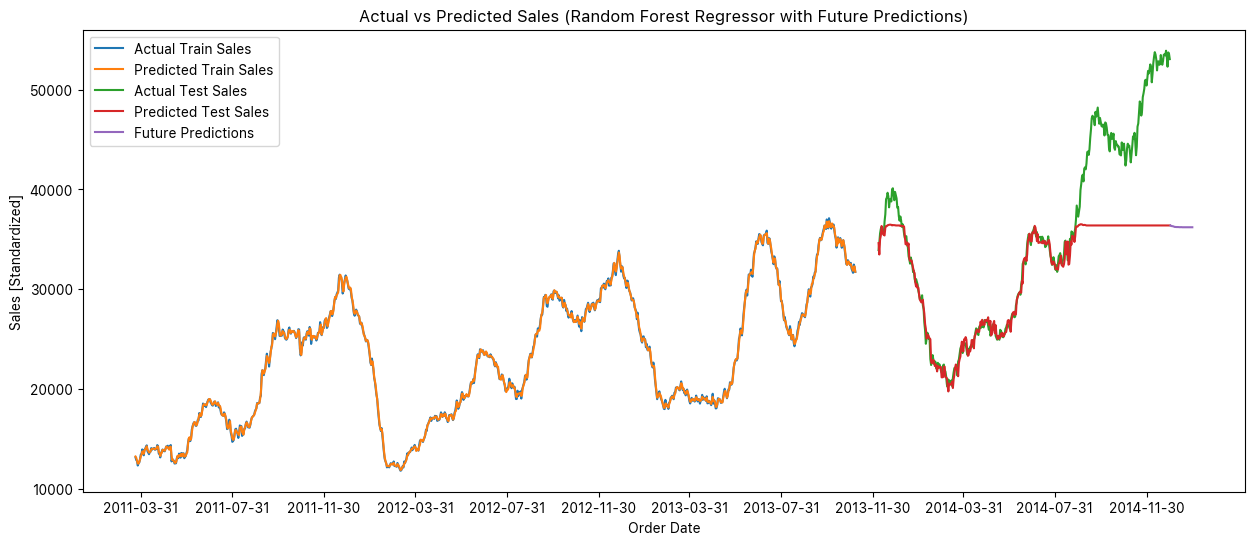

In [48]:
# Plot results
plot_sales(df_comparison_train_rf, df_comparison_test_rf, df_future_rf, 
           "Actual vs Predicted Sales (Random Forest Regressor with Future Predictions)")

3. XGBoost Regressor

In [52]:
# Train XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=50, random_state=24)
xgb_model.fit(X_train_rf, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=24, ...)

In [53]:
# Predict sales for train and test datasets using XGBoost
y_pred_train_xgb = predict_and_inverse_transform(xgb_model, X_train_rf, scaler)
y_pred_test_xgb  = predict_and_inverse_transform(xgb_model, X_test_rf, scaler)

df_comparison_train_xgb = pd.DataFrame({'Order Date': train_dates, 
                                        'Actual Sales': scaler.inverse_transform(y_train.reshape(-1, 1))[:, 0], 
                                        'Predicted Sales': y_pred_train_xgb})
df_comparison_test_xgb  = pd.DataFrame({'Order Date': test_dates, 
                                        'Actual Sales': scaler.inverse_transform(y_test.reshape(-1, 1))[:, 0], 
                                        'Predicted Sales': y_pred_test_xgb})

In [55]:
future_input_xgb    = X_test_rf[-1:].copy()  # Use the last available test data
y_future_pred_xgb   = generate_future_predictions(xgb_model, future_input_xgb, future_prediction_days, scaler)
df_future_xgb       = pd.DataFrame({'Order Date': predict_period_dates, 'Predicted Sales': y_future_pred_xgb})

In [56]:
# Evaluate models
evaluate_model(df_comparison_train_xgb, df_comparison_test_xgb, "XGBoost Regressor Model")

XGBoost Regressor Model Performance:

Train Scores

Train MSE: 5906.0305
Train MAE: 56.4352
Train R2 Score: 0.9999

Test Scores

Test MSE: 48273969.6555
Test MAE: 4131.4550
Test R2 Score: 0.4671



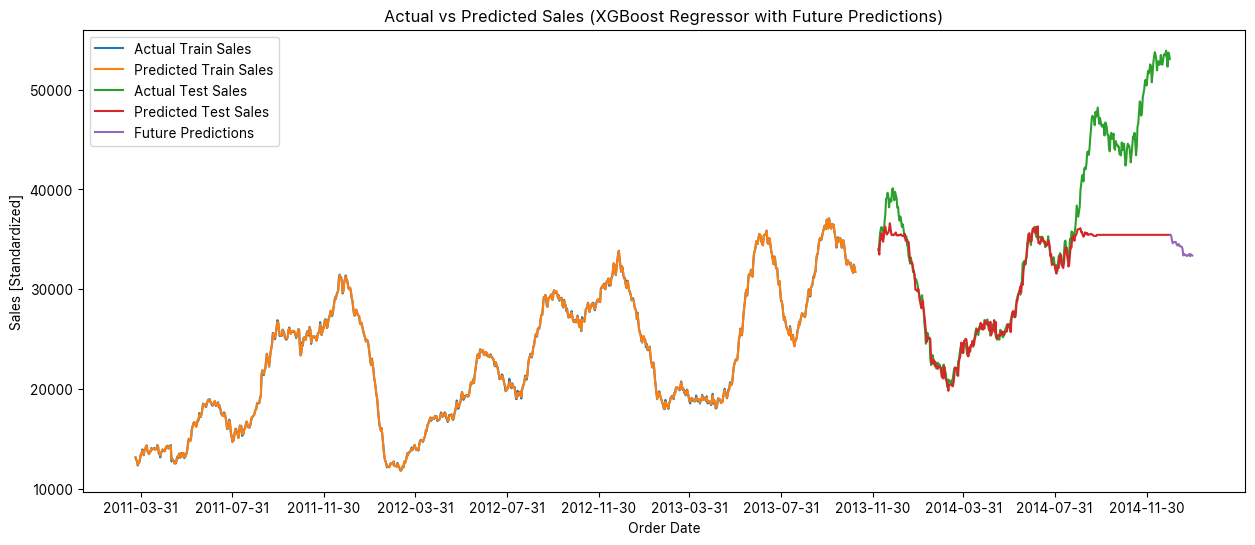

In [57]:
plot_sales(df_comparison_train_xgb, df_comparison_test_xgb, df_future_xgb,
           "Actual vs Predicted Sales (XGBoost Regressor with Future Predictions)")